In [1]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52


     |████████████████████████████████| 38.2 MB 1.3 MB/s 


In [3]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-wcko1tlm



In [1]:

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import albumentations as A
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
import cv2
import time
import os
import copy
import os

In [2]:
RANDOM_SEED = 786
def seed_everything(seed = RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
seed_everything()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
from pathlib import Path
path = Path('/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo')
os.listdir(path)

['Test', 'Train']

In [8]:
train_dir = '/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo/Train'
test_dir = '/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo/Test'

In [9]:
labels = os.listdir(train_dir)
print(labels)

['Porsche', 'Ford', 'Lexus', 'Acura', 'MercedesBenz', 'Mazda', 'Hyundai', 'BMW', 'Volkswagen', 'Toyota', 'Honda', 'Audi', 'Nissan', 'Tesla', 'Chevrolet', 'Infiniti', 'Lamborghini', 'KIA']


In [10]:
label_dict = {label : i for i, label in enumerate(sorted(os.listdir(train_dir)))}
inv_label_dic = {i : label for i, label in enumerate(sorted(os.listdir(train_dir)))}

In [11]:
def get_train_transforms():
    return albumentations.Compose(
    
        [
            
            A.Resize(256,256),
            A.HorizontalFlip(p = 0.5),
            A.VerticalFlip(p = 0.5),
            A.Rotate(limit = 180, p = 0.7),
            A.RandomBrightness(limit = 0.6, p = 0.5),
            A.Cutout(
                num_holes = 8, max_h_size = 8, max_w_size = 8,
                fill_value = 0, always_apply = False, p = 0.5
            ),
            A.ShiftScaleRotate(
                shift_limit = 0.25, scale_limit = 0.1, rotate_limit = 0
            ),
            A.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p = 1.0)   
        ]
    )
def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(256,256),
            albumentations.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p=1.0)
        ]
    )

In [30]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [31]:
data_dir = '/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo'

In [32]:
train_dataset = datasets.ImageFolder(train_dir,data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, data_transforms['val'])

In [33]:
bs = 8
train_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = 2, pin_memory = True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size = bs, shuffle = True, num_workers = 2, pin_memory = True, drop_last= True)

In [34]:
class_names = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


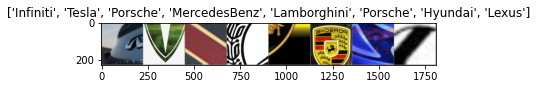

In [35]:
def show_batch(image, title):
  image = image.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  plt.imshow(image)
  if title:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show_batch(out, title = [class_names[x] for x in classes])

In [41]:
from tqdm import tqdm

In [73]:
def train(model, criterion, optimizer, scheduler, n_epochs = 100):
  start = time.time()
  for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    model.train()
    epoch_loss = 0
    print(f'Training Model')
    for image, label in tqdm(train_loader):
      optimizer.zero_grad()
      image = image.to(device)
      label = label.to(device)
      outputs = model(image)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, label)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * image.size(0)
      scheduler.step()
    epoch_loss = running_loss / len(train_dataset)  
    print('Train Loss : {:.3f}'.format((epoch_loss)))
  end = time.time()
  time_taken = end - start
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_taken // 60, time_taken % 60))

In [46]:
model= models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model= model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [74]:
train(model, criterion, optimizer_ft, exp_lr_scheduler, n_epochs=100)

Training Model


100%|██████████| 106/106 [00:14<00:00,  7.11it/s]


Train Loss : 3.035
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.20it/s]


Train Loss : 3.014
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.13it/s]


Train Loss : 3.009
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.98it/s]


Train Loss : 3.073
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.04it/s]


Train Loss : 3.006
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.04it/s]


Train Loss : 3.021
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.96it/s]


Train Loss : 2.996
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.93it/s]


Train Loss : 3.059
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.05it/s]


Train Loss : 3.053
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.10it/s]


Train Loss : 3.033
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.10it/s]


Train Loss : 2.981
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.00it/s]


Train Loss : 3.027
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.07it/s]


Train Loss : 2.978
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.03it/s]


Train Loss : 3.035
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.22it/s]


Train Loss : 3.003
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.11it/s]


Train Loss : 3.058
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.04it/s]


Train Loss : 2.965
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.97it/s]


Train Loss : 3.007
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.09it/s]


Train Loss : 3.041
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.03it/s]


Train Loss : 3.022
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.03it/s]


Train Loss : 3.012
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.97it/s]


Train Loss : 3.059
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.15it/s]


Train Loss : 3.055
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.78it/s]


Train Loss : 3.045
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.07it/s]


Train Loss : 2.986
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.14it/s]


Train Loss : 3.029
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.17it/s]


Train Loss : 2.995
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.13it/s]


Train Loss : 3.003
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.90it/s]


Train Loss : 3.003
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.00it/s]


Train Loss : 3.040
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.00it/s]


Train Loss : 2.990
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.98it/s]


Train Loss : 3.000
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.88it/s]


Train Loss : 2.985
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.98it/s]


Train Loss : 3.037
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.95it/s]


Train Loss : 3.040
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.94it/s]


Train Loss : 3.040
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.88it/s]


Train Loss : 3.012
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.92it/s]


Train Loss : 2.969
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.89it/s]


Train Loss : 3.026
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.87it/s]


Train Loss : 3.060
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.99it/s]


Train Loss : 3.083
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.99it/s]


Train Loss : 3.050
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.07it/s]


Train Loss : 3.072
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.97it/s]


Train Loss : 3.049
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.12it/s]


Train Loss : 3.024
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.01it/s]


Train Loss : 3.036
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.94it/s]


Train Loss : 3.010
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.03it/s]


Train Loss : 2.997
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.87it/s]


Train Loss : 3.033
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.97it/s]


Train Loss : 3.030
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.98it/s]


Train Loss : 3.001
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.94it/s]


Train Loss : 3.026
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.96it/s]


Train Loss : 3.006
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.09it/s]


Train Loss : 3.022
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.91it/s]


Train Loss : 3.052
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.01it/s]


Train Loss : 3.039
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.96it/s]


Train Loss : 3.005
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.11it/s]


Train Loss : 3.065
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.03it/s]


Train Loss : 3.010
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.03it/s]


Train Loss : 2.976
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.97it/s]


Train Loss : 2.988
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.94it/s]


Train Loss : 3.020
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.02it/s]


Train Loss : 3.025
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.21it/s]


Train Loss : 3.016
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.05it/s]


Train Loss : 3.026
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.98it/s]


Train Loss : 3.044
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.99it/s]


Train Loss : 3.001
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.06it/s]


Train Loss : 3.052
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.01it/s]


Train Loss : 2.986
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.99it/s]


Train Loss : 3.049
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.07it/s]


Train Loss : 2.999
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.06it/s]


Train Loss : 3.046
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.14it/s]


Train Loss : 3.040
Training Model


100%|██████████| 106/106 [00:15<00:00,  6.99it/s]


Train Loss : 2.998
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.06it/s]


Train Loss : 2.985
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.03it/s]


Train Loss : 2.984
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.15it/s]


Train Loss : 3.018
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.16it/s]


Train Loss : 2.981
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.40it/s]


Train Loss : 3.008
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.32it/s]


Train Loss : 2.994
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.17it/s]


Train Loss : 3.038
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.41it/s]


Train Loss : 3.035
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.23it/s]


Train Loss : 2.959
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.28it/s]


Train Loss : 3.022
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.30it/s]


Train Loss : 3.020
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.27it/s]


Train Loss : 3.017
Training Model


100%|██████████| 106/106 [00:15<00:00,  7.06it/s]


Train Loss : 3.074
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.26it/s]


Train Loss : 3.010
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.32it/s]


Train Loss : 3.017
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.38it/s]


Train Loss : 3.021
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.28it/s]


Train Loss : 3.008
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.25it/s]


Train Loss : 3.049
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.29it/s]


Train Loss : 3.049
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.34it/s]


Train Loss : 3.049
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.25it/s]


Train Loss : 3.011
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.25it/s]


Train Loss : 3.022
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.11it/s]


Train Loss : 2.960
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.26it/s]


Train Loss : 3.013
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.30it/s]


Train Loss : 2.999
Training Model


100%|██████████| 106/106 [00:14<00:00,  7.33it/s]

Train Loss : 2.965
Training complete in 24m 60s


In [77]:
test_losses = []
model.eval()
for epoch in range(20):
  num_correct = 0
  for image, labels in tqdm(test_loader):
    image = image.to(device)
    labels = labels.to(device)
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    num_correct += torch.sum(preds == labels)
    loss = criterion(outputs, labels)
    test_losses.append(loss.item())
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f} %".format(test_acc * 100))
  

100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

Test loss: 3.395
Test accuracy: 8.571 %


In [83]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                show_batch(inputs.cpu().data[j], title = None)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


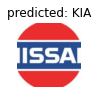

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


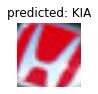

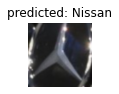

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


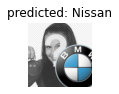

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


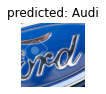

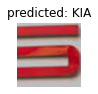

In [84]:
visualize_model(model)